In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36887")
client

<Client: 'tcp://127.0.0.1:36887' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import xrft
import gsw
import pandas
from scipy.interpolate import PchipInterpolator, interp1d
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
from fastjmd95 import drhods, drhodt
import MITgcmutils as mitutils
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.animation as animation  
%matplotlib inline
import pyamg
from scipy.sparse import coo_matrix, linalg, csr_matrix

In [3]:
# Physical coefficients 
grav = 9.81
rho0 = 999.8
Cp = 3.994e3
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20

# Time set-up
years = np.arange(1967,1968,dtype=int)
dnf = 2160 #time interval
nfile = 73 #time steps in a year
ini_time = 1419120
fin_time = 1574640
ntimes = np.arange(ini_time,fin_time+dnf,dnf).reshape(len(years),nfile)
dates = pandas.date_range(start='1967-01-03',end='1967-12-29',periods=73)

# Ensemble members 
membs = np.arange(100,148,dtype=int)

# Domain selection 
ychunk = 450
xchunk = 250
ystart = -15
yend = 50


In [4]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir_old = '/tank/topog/lsun/modewater/' # Saves cs_snap and maximum_cs
savedir = '/tank/spectre/lsun/modewater/' 
bdir = 'bcoor/'
twadir = 'TWA/'
figdir = '/tank/users/lsun/figures/modewater/' # Directory for figures

# Mask time-mean PV

In [5]:
def mask_filter(mask_tmp):
        XG_len = len(mask_tmp.XG.values)
        YG_len = len(mask_tmp.YG.values)

        d1_tmp = mask_tmp.isel(XG = slice(0, XG_len-1)).diff('XG')
        d2_tmp = mask_tmp.isel(XG = slice(1, XG_len)).diff('XG', label = 'lower')


        d3_tmp = mask_tmp.isel(YG = slice(0, YG_len-1)).diff('YG')
        d4_tmp = mask_tmp.isel(YG = slice(1, YG_len)).diff('YG', label = 'lower')


        return xr.where((xr.where(np.abs(d1_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) + 
                       xr.where(np.abs(d1_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d3_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0) +
                       xr.where(np.abs(d2_tmp) + np.abs(d4_tmp) == 0, mask_tmp.isel(XG = slice(1, XG_len-1), YG = slice(1, YG_len-1)), 0)
                      )>0, 1, 0)

def contour_mask(Pi, Pi_thres):
        # cells that are within the pool are marked. 
        mask_tmp = xr.where(Pi.where(Pi >= 0) <= Pi_thres, 1, 0)  # ignore negative PV


        mask = mask_filter(mask_tmp)
        i = 0
        while ((mask - mask_tmp).any() !=0):
            if (i > 4):
                break
            else:
                mask_tmp = mask
                mask = mask_filter(mask_tmp)
                i+=1
        print(i)        

        # the boundaries and outward corners are found.
        d1 = mask.diff('XG')
        d2 = mask.diff('XG', label = 'lower')

        mask_w = xr.where(xr.where(d1 == 1, 1, 0) + xr.where(d2 == 0, 1, 0) == 2, 1, 0)
        mask_e = xr.where(xr.where(d2 == -1, 1, 0) + xr.where(d1 == 0, 1, 0) == 2, 2, 0)

        d3 = mask.diff('YG')
        d4 = mask.diff('YG', label = 'lower')

        mask_s = xr.where(xr.where(d3 == 1, 1, 0) + xr.where(d4 == 0, 1, 0) == 2, 3, 0)
        mask_n = xr.where(xr.where(d4 == -1, 1, 0) + xr.where(d3 == 0, 1, 0) == 2, 6, 0)

        mask_b = mask_w + mask_e  + mask_s + mask_n
        mask_int = (xr.where(mask == 1, 9, 0) + mask_b).where(xr.where(mask == 1, 9, 0) + mask_b <= 9, 0)

        # inward corners
        mask_tmp2 = mask_b + mask_int

        d1_2 = mask_tmp2.diff('XG')
        d2_2 = mask_tmp2.diff('XG', label = 'lower')

        d3_2 = mask_tmp2.diff('YG')
        d4_2 = mask_tmp2.diff('YG', label = 'lower')

        c_sw = xr.where(d3_2 == 8, 1, 0) + xr.where(d1_2 == 6, 1, 0) 
        c_nw = xr.where(d4_2 == -8, 1, 0) + xr.where(d1_2 == 3, 1, 0) 
        c_se = xr.where(d3_2 == 7, 1, 0) + xr.where(d2_2 == -6, 1, 0) 
        c_ne = xr.where(d4_2 == -7, 1, 0) + xr.where(d2_2 == -3, 1, 0) 
        corner = (xr.where(c_sw == 2, 10, 0) + xr.where(c_nw == 2, 11, 0) +
                 xr.where(c_se == 2, 12, 0) + xr.where(c_ne == 2, 13, 0))
        mask_b_new = mask_b + corner
        mask_int = (mask_int + corner).where(mask_int + corner == 9,0) 
        mask_new = mask_int + mask_b_new
        
        return mask_new, mask_b_new

In [14]:
# boundaries of mode water with different threshold of PV

Pi_thres_range = [0.25e-9] #[0.22e-9, 0.25e-9, 0.28e-9] # threshold of low PV pool
for Pi_thres in Pi_thres_range:
    year = years[0]
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,1],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
    XG_sub = [279, 326]
    YG_sub = [24, 41]
    delta_isub = [17, 26] # buoyancy = -0.245, -0.254
    
    for itime in ntimes[0]:     
        dsPV = xr.open_zarr(op.join(savedir,twadir,'run%4d/ErtelPV_G/%010d/' 
                                   % (year,itime))
                          ).reset_coords(drop=True).sel(YG=slice(ystart-12**-1,yend+2*12**-1)
                                                       ).chunk({'YG':ychunk,'XG':xchunk})
        if itime == ntimes[0,0]:
            Pi = dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                             YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
            buoyancy = - grav * Pi.delta_outer * rho0**-1
        else:
            Pi = xr.concat([Pi,
                            dsPV.Pi.sel(XG = slice(XG_sub[0],XG_sub[1]), 
                                        YG = slice(YG_sub[0],YG_sub[1])) * grav**-1
                           ],'ntime')
    
    Pi.coords['ntime'] = ('ntime',range(73))   

    Pi_mean = Pi.where(Pi>0).mean('ntime',skipna=True) 
    
    count = 0
    
    for d_index in range(delta_isub[0],delta_isub[1]): 
        mask_new, mask_b_new = contour_mask(Pi_mean.isel(delta_outer = d_index), Pi_thres)
        if count == 0:
            mask = mask_new
            mask_b = mask_b_new
        else:
            mask = xr.concat([mask, mask_new], dim = 'delta_outer')
            mask_b = xr.concat([mask_b, mask_b_new], dim = 'delta_outer')

        count += 1

dsave = mask.to_dataset(name='PVmask').chunk({'YG':ychunk,'XG':xchunk})   
dsave['mask_b'] = mask_b.chunk({'YG':ychunk,'XG':xchunk})   

dsave.to_zarr(op.join(savedir,twadir,'run%4d/meanPV_mask_%2d/' 
                                        % (year,Pi_thres *1e11)), mode='w')
dsave.close()


2
1
2
2
3
3
4
4
3


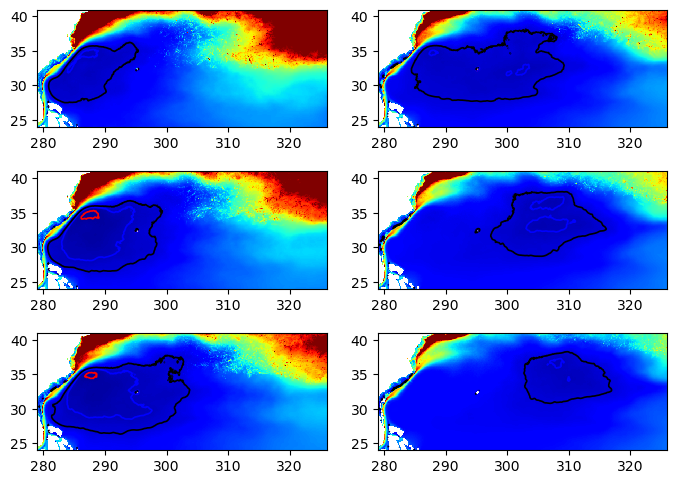

In [40]:
delta_isub = range(19,25,1) 
labels = [['a','b','c'],
          ['d','e','f']]

fig, ax = plt.subplots(figsize=(9,5), nrows=3, ncols=2)
fig.tight_layout()
plt.subplots_adjust(left=0.1, right = 0.8)

dd = 0
for d_index in delta_isub:
    im0 = ax[np.mod(dd,3),dd//3].pcolormesh(Pi_mean.isel(delta_outer = d_index).XG, 
                            Pi_mean.isel(delta_outer = d_index).YG, 
                            Pi_mean.isel(delta_outer = d_index), 
                            vmin=0.5e-10, vmax=2e-9, cmap='jet', 
                            rasterized=True
                           )   
    ax[np.mod(dd,3),dd//3].contour(Pi_mean.isel(delta_outer = d_index).XG, 
                     Pi_mean.isel(delta_outer = d_index).YG, 
                     Pi_mean.isel(delta_outer = d_index),
                     levels = [1.5e-10,2e-10,2.5e-10],
                     linewidths=1.2, colors=['w','r','k'])
    dd += 1
    # ax.text(0.05, 0.9, labels[dd], 
    #            horizontalalignment = 'center', fontsize=13,
    #            verticalalignment = 'center', transform = ax[dd,0].transAxes)
    # if dd == 0:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.246')
    # elif dd == 1:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.25')
    # elif dd == 2:
    #     ax[dd,0].set_ylabel(r'$\tilde{b}$=-0.254')


In [101]:
Pi_sub = Pi_mean.isel(delta_outer = 21)


# Determine solver domain

In [6]:
# Select a subdomain based on the mask of PV
Pi_thres = 0.25e-9
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,0],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
grid = Grid(ds, periodic=['X'])

dsm = xr.open_zarr(op.join(savedir,twadir,'run%4d/meanPV_mask_%2d/' 
                                                % (years[0],Pi_thres *1e11)
                              ))
mask = dsm.PVmask.isel(delta_outer = 4) 

# grid spacings 
dxGG_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dxC, 'Y') ** -1).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dxGG_r')])
dyGG_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dyC, 'X') ** -1).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dyGG_r')])
dxGG2_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dxC, 'Y') ** -2).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dxGG2_r')])
dyGG2_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dyC, 'X') ** -2).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dyGG2_r')])
ds.close()

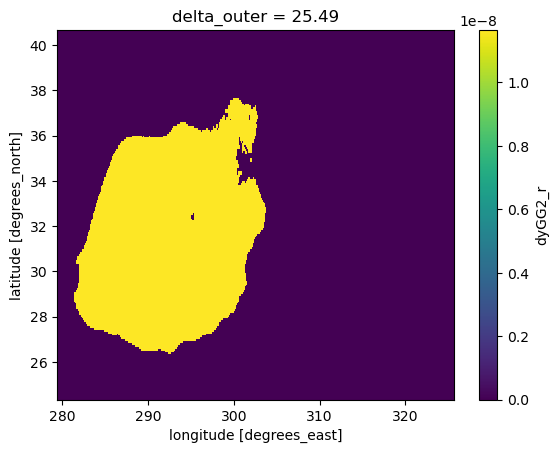

In [8]:
hy2.plot()

In [9]:
# Select a subdomain based on the mask of PV
Pi_thres = 0.25e-9
ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=ntimes[0,0],
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))
grid = Grid(ds, periodic=['X'])

dsm = xr.open_zarr(op.join(savedir,twadir,'run%4d/meanPV_mask_%2d/' 
                                                % (years[0],Pi_thres *1e11)
                              ))
mask = dsm.PVmask.isel(delta_outer = 4) 

# grid spacings 
dxGG_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dxC, 'Y') ** -1).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dxGG_r')])
dyGG_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dyC, 'X') ** -1).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dyGG_r')])
dxGG2_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dxC, 'Y') ** -2).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dxGG2_r')])
dyGG2_r = xr.combine_by_coords([mask, 
                               (grid.interp(ds.dyC, 'X') ** -2).sel(
                                   XG = mask.XG, 
                                   YG = mask.YG).rename('dyGG2_r')])
ds.close()

# grid spacing at masked points 
hx_w = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 7,0)
     + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 1,0)
     + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 4,0)
       )

hx_e = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 8,0)
     + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 2,0)
     + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 5,0)
       )

hy_n = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 7,0)
     + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 6,0)
     + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 8,0)
       )

hy_s = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 4,0)
     + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 3,0)
     + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 5,0)
       )

hx2 = dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask >0, 0)

hy2 = dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask >0, 0)

# coefficients of 5 elements C_ij, C_i+1,j, C_i-1,j, C_i,j+1, C_i,j-1
cij_x = - hx2
for index in [6,9,3,10,11,12,13]: # - 2/dx^2 for interiors
    cij_x = cij_x - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) 
cij_y = - hy2
for index in [1,9,2,10,11,12,13]: # - 2/dy^2 for interiors
    cij_y = cij_y - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) 
cij = cij_x + cij_y

cip = hx2
for index in [8,2,5]:
    cip = cip - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i+1,j on eastern boundaries
cim = hx2
for index in [7,1,4]:
    cim = cim - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i-1,j on western boundaries
cjp = hy2
for index in [7,6,8]:
    cjp = cjp - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j+1 on northern boundaries
cjm = hy2
for index in [4,3,5]:
    cjm = cjm - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j-1 on southern boundaries
    
# locations of 5 elements
[n, m] = mask.shape
r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
c_cij = r_cij 

r_cip = [m*j + i for j in range(0,n) for i in range(0,m-1)], 
c_cip = [m*j + i + 1 for j in range(0,n) for i in range(0,m-1)] 

r_cim = [m*j + i for j in range(0,n) for i in range(1,m)], 
c_cim = [m*j + i - 1 for j in range(0,n) for i in range(1,m)] 

r_cjp = [m*(j+1) + i for j in range(0,n-1) for i in range(0,m)]
c_cjp = [m*j + i for j in range(0,n-1) for i in range(0,m)]

r_cjm = [m*(j-1) + i for j in range(1,n) for i in range(0,m)]
c_cjm = [m*j + i for j in range(1,n) for i in range(0,m)]

# generate sparse matrix A
diag = np.append(np.append(cij.to_numpy().reshape(m*n), # along row then column
                              (cip.to_numpy())[:,0:m-1].reshape((m-1)*n)
                             ),
                    (cim.to_numpy())[:,1:m].reshape((m-1)*n)
                   )
r_D = np.append(np.append(r_cij, r_cip), r_cim)
c_D = np.append(np.append(c_cij, c_cip), c_cim)
D = coo_matrix((diag, (r_D, c_D)), shape=(m*n,m*n)).tocsr()

Is = np.append((cjp.to_numpy())[0:n-1,:].reshape((n-1)*m), 
               (cjm.to_numpy())[1:n,:].reshape((n-1)*m))
r_I = np.append(r_cjp, r_cjm)
c_I = np.append(c_cjp, c_cjm)

I = coo_matrix((Is, (r_I, c_I)), shape=(m*n,m*n)).tocsr()
A = D + I


In [17]:
print(A)

  (13062, 13062)	-2.5240386e-08
  (13062, 13063)	1.3590308e-08
  (13062, 13600)	1.1650078e-08
  (13063, 13062)	1.3590308e-08
  (13063, 13063)	-3.8830695e-08
  (13063, 13064)	1.3590308e-08
  (13063, 13601)	1.1650078e-08
  (13064, 13063)	1.3590308e-08
  (13064, 13064)	-3.8830695e-08
  (13064, 13065)	1.3590308e-08
  (13064, 13602)	1.1650078e-08
  (13065, 13064)	1.3590308e-08
  (13065, 13065)	-3.8830695e-08
  (13065, 13066)	1.3590308e-08
  (13065, 13603)	1.1650078e-08
  (13066, 13065)	1.3590308e-08
  (13066, 13066)	-2.5240386e-08
  (13066, 13604)	1.1650078e-08
  (13596, 13596)	-2.5259967e-08
  (13596, 13597)	1.3609888e-08
  (13596, 14134)	1.1650078e-08
  (13597, 13596)	1.3609888e-08
  (13597, 13597)	-3.8869857e-08
  (13597, 13598)	1.3609888e-08
  (13597, 14135)	1.1650078e-08
  :	:
  (85781, 85781)	-4.640058e-08
  (85781, 85782)	1.737525e-08
  (85782, 85244)	1.1650078e-08
  (85782, 85781)	1.737525e-08
  (85782, 85782)	-4.640058e-08
  (85782, 85783)	1.737525e-08
  (85783, 85245)	1.1650078e-0

# Bernoulli solver

In [11]:
def bernoulli(f, g_w, g_e, g_n, g_s, mask): 
    
    # Select a subdomain based on the mask of PV
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,years[0])), 
                                     grid_dir=gdir,
                                     prefix=['snap_diagOcn'], 
                                     delta_t=2e2, iters=ntimes[0,0],
                                     chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                    ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                          YG=slice(ystart-12**-1,yend+2*12**-1))
    grid = Grid(ds, periodic=['X'])

    # grid spacings 
    dxGG_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dxC, 'Y') ** -1).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dxGG_r')])
    dyGG_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dyC, 'X') ** -1).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dyGG_r')])
    dxGG2_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dxC, 'Y') ** -2).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dxGG2_r')])
    dyGG2_r = xr.combine_by_coords([mask, 
                                   (grid.interp(ds.dyC, 'X') ** -2).sel(
                                       XG = mask.XG, 
                                       YG = mask.YG).rename('dyGG2_r')])
    ds.close()

    # grid spacing at masked points 
    hx_w = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 7,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 1,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 4,0)
           )

    hx_e = (dxGG_r.dxGG_r.where(dxGG_r.PVmask == 8,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 2,0)
         + dxGG_r.dxGG_r.where(dxGG_r.PVmask == 5,0)
           )

    hy_n = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 7,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 6,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 8,0)
           )

    hy_s = (dyGG_r.dyGG_r.where(dyGG_r.PVmask == 4,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 3,0)
         + dyGG_r.dyGG_r.where(dyGG_r.PVmask == 5,0)
           )

    hx2 = dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask >0, 0)

    hy2 = dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask >0, 0)

    # coefficients of 5 elements C_ij, C_i+1,j, C_i-1,j, C_i,j+1, C_i,j-1
    cij_x = - hx2
    for index in [6,9,3,10,11,12,13]: # - 2/dx^2 for interiors
        cij_x = cij_x - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) 
    cij_y = - hy2
    for index in [1,9,2,10,11,12,13]: # - 2/dy^2 for interiors
        cij_y = cij_y - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) 
    cij = cij_x + cij_y

    cip = hx2
    for index in [8,2,5]:
        cip = cip - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i+1,j on eastern boundaries
    cim = hx2
    for index in [7,1,4]:
        cim = cim - dxGG2_r.dxGG2_r.where(dxGG2_r.PVmask ==index, 0) # no c_i-1,j on western boundaries
    cjp = hy2
    for index in [7,6,8]:
        cjp = cjp - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j+1 on northern boundaries
    cjm = hy2
    for index in [4,3,5]:
        cjm = cjm - dyGG2_r.dyGG2_r.where(dyGG2_r.PVmask ==index, 0) # no c_i,j-1 on southern boundaries

    # locations of 5 elements
    [n, m] = mask.shape
    r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
    c_cij = r_cij 

    r_cip = [m*j + i for j in range(0,n) for i in range(0,m-1)], 
    c_cip = [m*j + i + 1 for j in range(0,n) for i in range(0,m-1)] 

    r_cim = [m*j + i for j in range(0,n) for i in range(1,m)], 
    c_cim = [m*j + i - 1 for j in range(0,n) for i in range(1,m)] 

    r_cjp = [m*(j+1) + i for j in range(0,n-1) for i in range(0,m)]
    c_cjp = [m*j + i for j in range(0,n-1) for i in range(0,m)]

    r_cjm = [m*(j-1) + i for j in range(1,n) for i in range(0,m)]
    c_cjm = [m*j + i for j in range(1,n) for i in range(0,m)]

    # generate sparse matrix A
    diag = np.append(np.append(cij.to_numpy().reshape(m*n), # along row then column
                                  (cip.to_numpy())[:,0:m-1].reshape((m-1)*n)
                                 ),
                        (cim.to_numpy())[:,1:m].reshape((m-1)*n)
                       )
    r_D = np.append(np.append(r_cij, r_cip), r_cim)
    c_D = np.append(np.append(c_cij, c_cip), c_cim)
    D = coo_matrix((diag, (r_D, c_D)), shape=(m*n,m*n)).tocsr()

    Is = np.append((cjp.to_numpy())[0:n-1,:].reshape((n-1)*m), 
                   (cjm.to_numpy())[1:n,:].reshape((n-1)*m))
    r_I = np.append(r_cjp, r_cjm)
    c_I = np.append(c_cjp, c_cjm)

    I = coo_matrix((Is, (r_I, c_I)), shape=(m*n,m*n)).tocsr()
    A = D + I

    # RHS of elliptic equation, boundary conditions, grid spacing at grid points (XG,YG).
    hx2 = hx2.to_numpy()
    hy2 = hy2.to_numpy()
    
    [n, m] = f.shape #lengths of j and i

    # separate points for 4 boundaries and interior
    bc_w = [0] 
    bc_e = [m-1]
    bc_i = bc_w + bc_e # boundaries in west and east
    interior_i = [i for i in range(1,m-1)]

    bc_n = [n-1]
    bc_s = [0]
    bc_j = bc_s + bc_n # boundaries in north and south 
    interior_j = [j for j in range(1,n-1)]

    
    # construct RHS with boundary conditions
    # fill in the boundaries of the domain
    g_bc = np.zeros([n,m])
    g_bc[:,bc_w] = (g_w * dxGG_r.dxGG_r).isel(XG = bc_w).to_numpy()
    g_bc[:,bc_e] = (g_e * dxGG_r.dxGG_r).isel(XG = bc_e).to_numpy()

    g_bc[bc_n,:] = (g_n * dyGG_r.dyGG_r).isel(YG = bc_n).to_numpy()
    g_bc[bc_s,:] = (g_s * dyGG_r.dyGG_r).isel(YG = bc_s).to_numpy()
    
    # consider the lands
    g = (g_w * hx_w + g_e * hx_e + g_n * hy_n +g_s * hy_s).fillna(0).to_numpy()...
        + g_bc

    
  
    # construct RHS with boundary conditions
    
    b = (f.to_numpy() - g).reshape(m*n)
    
    
    # entries for diagnol matrix D_n(m,m)
#     # coefficients for Bij
#     cij_x = -2 * hx2
#     cij_x[:,bc_i] = - hx2[:,bc_i] #entries for western/eastern boundaries are replaced. these are where the boundary condition should be added to b later
#     cij_y = -2 * hy2
#     cij_y[bc_j,:] = - hy2[bc_j,:] 
#     cij = cij_x + cij_y

#     # chop the boundaries for the square domain. 
#     cip = hx2[:,bc_w+interior_i] #B_i+1,j 
#     cim = hx2[:,interior_i+bc_e] #B_i-1,j

#     diagnols = np.append(np.append(cij.reshape(m*n), # along row then column
#                               cip.reshape((m-1)*n)
#                              ),
#                     cim.reshape((m-1)*n)
#                    )

#     # indices of the entries in A
#     r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
#     c_cij = r_cij #B_ij

#     range_ip = [i + 1 for i in (bc_w + interior_i)]
#     r_cip = [m*j + i for j in range(0,n) for i in (bc_w + interior_i)], 
#     c_cip = [m*j + i for j in range(0,n) for i in range_ip] #B_i+1,j 

#     range_im = [i - 1 for i in (interior_i + bc_e)]
#     r_cim = [m*j + i for j in range(0,n) for i in (interior_i + bc_e)], 
#     c_cim = [m*j + i for j in range(0,n) for i in range_im] #B_i-1,j

#     rows = np.append(np.append(r_cij, r_cip), r_cim)
#     cols = np.append(np.append(c_cij, c_cip), c_cim)

#     # generate sparse matrix D
#     D = coo_matrix((diagnols, (rows, cols)), shape=(m*n,m*n)).tocsr()

#     # entries for identity matrices
#     cjp = hy2[bc_s + interior_j,:] #B_i,j+1
#     cjm = hy2[interior_j + bc_n,:] #B_i,j-1

#     Is = np.append(cjp.reshape((n-1)*m), cjm.reshape((n-1)*m))

#     # indices of the entries in A
#     range_ip = [j + 1 for j in (bc_s + interior_j)]
#     r_cjp = [m*j + i for j in (bc_s + interior_j) for i in range(0,m)]
#     c_cjp = [m*j + i for j in range_ip for i in range(0,m)]

#     range_im = [j - 1 for j in (interior_j + bc_n)]
#     r_cjm = [m*j + i for j in (interior_j + bc_n) for i in range(0,m)]
#     c_cjm = [m*j + i for j in range_im for i in range(0,m)]

#     rows_i = np.append(r_cjp, r_cjm)
#     cols_i = np.append(c_cjp, c_cjm)

#     I = coo_matrix((Is, (rows_i, cols_i)), shape=(m*n,m*n)).tocsr()
#     A = D + I

    sol, istop, itn, r1norm = linalg.lsqr(A,b)[:4]

    return sol.reshape(n,m), istop, itn, r1norm

## Bernoulli from definition 

$\nabla^2 B = \nabla^2(\frac{u^2+v^2}{2} + m)$

In [18]:
year = years[0]

for itime in ntimes[0]:
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    grid = Grid(ds, periodic=['X'])
    dxC_r = ds.dxC ** -1 
    dyC_r = ds.dyC ** -1
    
    KE = (grid.interp(dsb.uhat ** 2, 'X') 
        + grid.interp(dsb.vhat ** 2, 'Y')
         )/2
    
    if itime == ntimes[0,0]:
        # compute dBdx, dBdy from given montgomery potential gradients
        dBdx = grid.diff(KE, 'X') * dxC_r + dsb.mbxb 
        dBdy = grid.diff(KE, 'Y') * dyC_r + dsb.mbyb 
        # compute dBdxx, dBdyy
        dBdxx = grid.interp(grid.diff(dBdx, 'X'), 'X') * dxC_r 
        dBdyy = grid.interp(grid.diff(dBdy, 'Y'), 'Y') * dyC_r
        
    else:
        dBdx_tmp = grid.diff(KE, 'X') * dxC_r + dsb.mbxb
        dBdy_tmp = grid.diff(KE, 'Y') * dyC_r + dsb.mbyb
        dBdx = xr.concat([dBdx, dBdx_tmp], 'itime')
        dBdy = xr.concat([dBdy, dBdy_tmp], 'itime')
        
        dBdxx = xr.concat([dBdxx, grid.interp(grid.diff(dBdx_tmp, 'X'), 'X') * dxC_r], 'itime')
        dBdyy = xr.concat([dBdyy, grid.interp(grid.diff(dBdy_tmp, 'Y'), 'Y') * dyC_r], 'itime')
    
    ds.close()
    dsb.close()

nabla2_B = grid.interp(dBdxx, 'Y') + grid.interp(dBdyy, 'X')


In [19]:
# Select a subdomain based on the mask of PV

d_index = 21
dBdx_mean = grid.interp(dBdx.mean('itime'), 'Y').isel(delta_outer = d_index
                                   ).sel(XG = mask.XG, 
                                         YG = mask.YG)
dBdy_mean = grid.interp(dBdy.mean('itime'), 'X').isel(delta_outer = d_index
                                   ).sel(XG = mask.XG, 
                                         YG = mask.YG)
nabla2B_mean = (nabla2_B.mean('itime')).isel(delta_outer = d_index
                                   ).sel(XG = mask.XG, 
                                         YG = mask.YG)

# solB, istopB, itnB, r1normB = bernoulli(nabla2B_mean, -dBdx_mean, dBdx_mean, dBdy_mean, -dBdy_mean, hx2, hy2)

In [43]:
f, g_w, g_e, g_n, g_s = nabla2B_mean, -dBdx_mean, dBdx_mean, dBdy_mean, -dBdy_mean
f = f.where(mask >0,0)
# construct RHS with boundary conditions
g = (g_w * hx_w + g_e * hx_e + g_n * hy_n +g_s * hy_s).fillna(0)
b = (f - g).to_numpy().reshape(m*n)

In [60]:
p = []
for i in range(m):
    for j in range(n):
        if b[m*j+i] != 0:
            p.append(m*j+i)

            

In [ ]:
A_tmp = csr_matrix(A[p,p])
plt.plot(A)

In [ ]:
plt

In [77]:
A_tmp = (A[:,p])[p,:]
b_tmp = b[p]

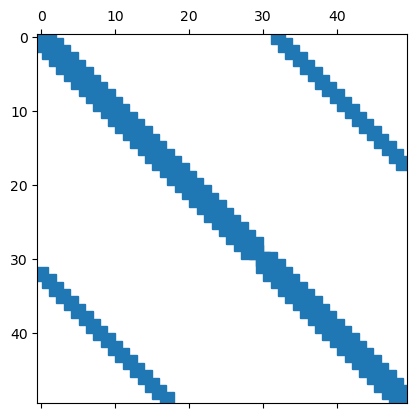

In [86]:
plt.spy(A_tmp[100:150,100:150])

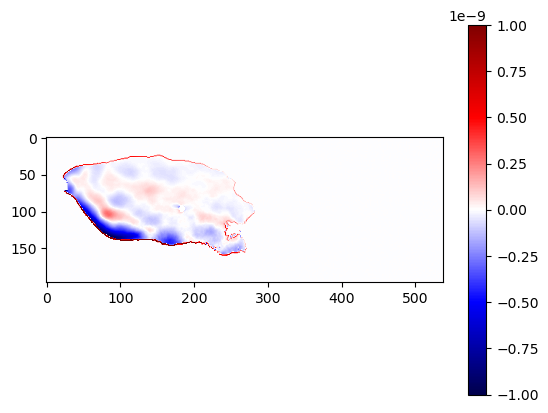

In [44]:
BB = (b.reshape(n,m))

plt.imshow(BB, cmap = 'seismic', vmin = -1e-9, vmax = 1e-9)
plt.colorbar()

In [78]:
sol, istop, itn, r1norm = linalg.lsqr(A_tmp,b_tmp)[:4]

In [1]:
sol

NameError: name 'sol' is not defined

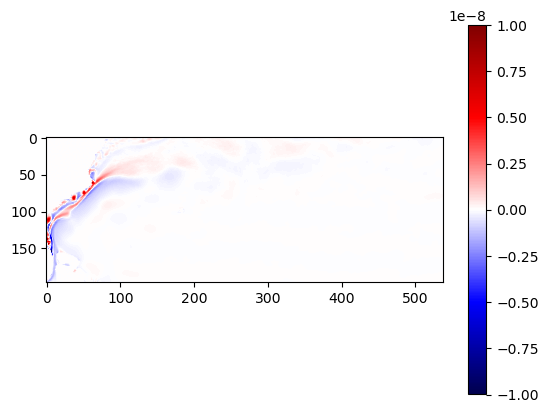

In [40]:
plt.imshow(np.flip(ff,0), cmap = 'seismic', vmax = 1e-8, vmin = -1e-8)
plt.colorbar()

TypeError: Invalid shape (23795,) for image data

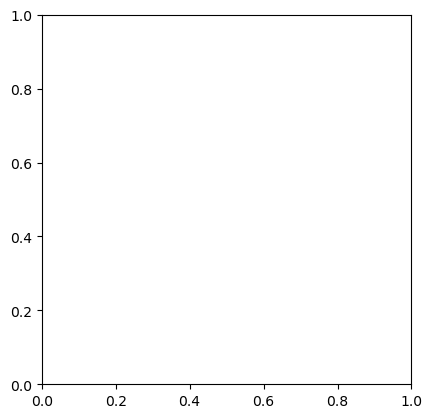

In [80]:
plt.imshow(np.flip(sol,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.title('Total Bernoulli')
plt.figure()

KeyboardInterrupt: 

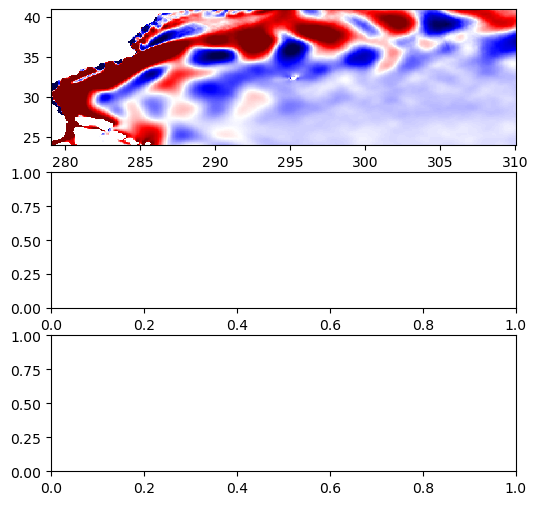

In [50]:
fig, ax = plt.subplots(figsize = (6,6), nrows = 3, ncols = 1)
ax[0].pcolormesh(dBdx_mean.XG, dBdx_mean.YG, dBdx_mean,
                vmin = -1e-5, vmax = 1e-5, rasterized=True, cmap = 'seismic')
ax[1].pcolormesh(dBdy_mean.XG, dBdy_mean.YG, dBdy_mean,
                vmin = -1e-5, vmax = 1e-5, rasterized=True, cmap = 'seismic')
ax[2].pcolormesh(nabla2B_mean.XG, nabla2B_mean.YG, nabla2B_mean,
                vmin = -1e-9, vmax = 1e-9, rasterized=True, cmap = 'seismic')


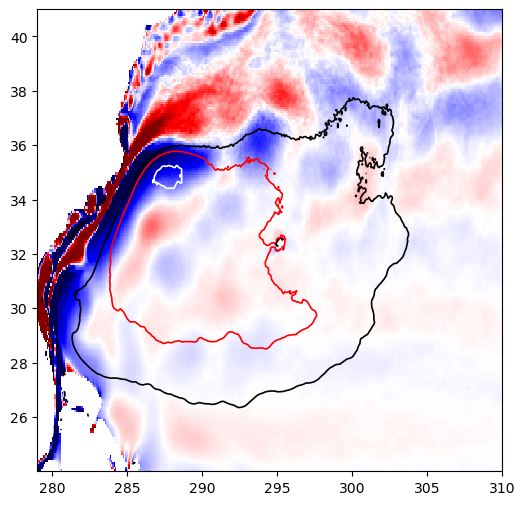

In [57]:
fig, ax = plt.subplots(figsize = (6,6))
ax.pcolormesh(nabla2B_mean.XG, nabla2B_mean.YG, nabla2B_mean,
                vmin = -1e-9, vmax = 1e-9, rasterized=True, cmap = 'seismic')
ax.contour(Pi_sub.XG, 
         Pi_sub.YG, 
         Pi_sub,
         levels = [1.5e-10,2e-10,2.5e-10],
         linewidths=1.2, colors=['w','r','k'])

## Coefficients for finite differencing

define boundaries

In [16]:
[n, m] = nabla2B_mean.shape #lengths of j and i

# separate points for 4 boundaries and interior
bc_w = [0] 
bc_e = [m-1]
bc_i = bc_w + bc_e # boundaries in west and east
interior_i = [i for i in range(1,m-1)]

bc_n = [n-1]
bc_s = [0]
bc_j = bc_s + bc_n # boundaries in north and south 
interior_j = [j for j in range(1,n-1)]

construct b

In [19]:
# construct RHS with boundary conditions

g_bc = np.zeros([n,m])
g_bc[:,bc_w] = (- dBdx_mean * dxGG ** -1).isel(XG = bc_w).to_numpy()
g_bc[:,bc_e] = (dBdx_mean * dxGG ** -1).isel(XG = bc_e).to_numpy()

g_bc[bc_n,:] = (dBdy_mean * dyGG ** -1).isel(YG = bc_n).to_numpy()
g_bc[bc_s,:] = (- dBdy_mean * dyGG ** -1).isel(YG = bc_s).to_numpy()

b = (nabla2B_mean.to_numpy() - g_bc).reshape(m*n)

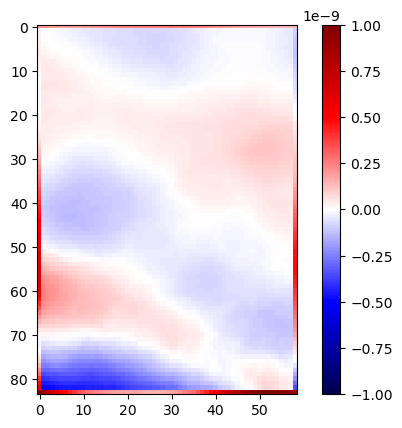

In [20]:
plt.imshow(b.reshape(n,m),cmap = 'seismic')
plt.colorbar()
plt.clim([-1e-9, 1e-9])

construct matrix A

In [21]:
# grid spacings
hx2 = (dxGG ** -2).to_numpy() # hx2 varies in j-direction 
hy2 = (dyGG ** -2).to_numpy()


In [22]:
# entries for diagnol matrix D_n(m,m)
# coefficients for Bij
cij_x = -2 * hx2
cij_x[:,bc_i] = - hx2[:,bc_i] #entries for western/eastern boundaries are replaced. these are where the boundary condition should be added to b later
cij_y = -2 * hy2
cij_y[bc_j,:] = - hy2[bc_j,:] 
cij = cij_x + cij_y

# for irregular domain, we should replace entries for irregular points (points on the boundaries inside a square domain) by 0 first then chop the boundaries for the square domain. 
cip = hx2[:,bc_w + interior_i] #B_i+1,j 
cim = hx2[:,interior_i + bc_e] #B_i-1,j

diagnols = np.append(np.append(cij.reshape(m*n), # along row then column
                          cip.reshape((m-1)*n)
                         ),
                cim.reshape((m-1)*n)
               )

In [23]:
# indices of the entries in A
r_cij = [m*j + i for j in range(0,n) for i in range(0,m)], 
c_cij = r_cij #B_ij

range_ip = [i + 1 for i in (bc_w + interior_i)]
r_cip = [m*j + i for j in range(0,n) for i in (bc_w + interior_i)], 
c_cip = [m*j + i for j in range(0,n) for i in range_ip] #B_i+1,j 

range_im = [i - 1 for i in (interior_i + bc_e)]
r_cim = [m*j + i for j in range(0,n) for i in (interior_i + bc_e)], 
c_cim = [m*j + i for j in range(0,n) for i in range_im] #B_i-1,j

rows = np.append(np.append(r_cij, r_cip), r_cim)
cols = np.append(np.append(c_cij, c_cip), c_cim)

# generate sparse matrix D
D = coo_matrix((diagnols, (rows, cols)), shape=(m*n,m*n)).tocsr()

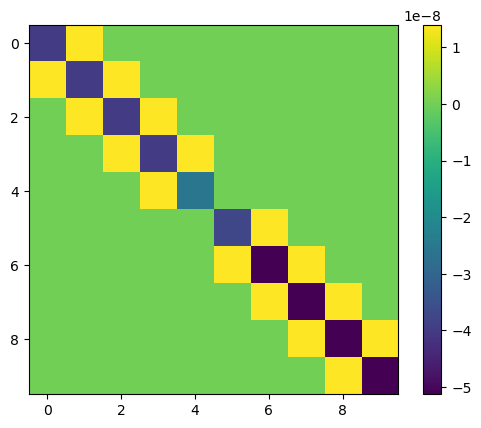

In [24]:
# test if D is constructed well
plt.imshow(D[m-5:m+5,m-5:m+5].todense())
plt.colorbar()
plt.show()

In [25]:
# entries for identity matrices
cjp = hy2[bc_s + interior_j,:] #B_i,j+1
cjm = hy2[interior_j + bc_n,:] #B_i,j-1

Is = np.append(cjp.reshape((n-1)*m), cjm.reshape((n-1)*m))

# indices of the entries in A
range_ip = [j + 1 for j in (bc_s + interior_j)]
r_cjp = [m*j + i for j in (bc_s + interior_j) for i in range(0,m)]
c_cjp = [m*j + i for j in range_ip for i in range(0,m)]

range_im = [j - 1 for j in (interior_j + bc_n)]
r_cjm = [m*j + i for j in (interior_j + bc_n) for i in range(0,m)]
c_cjm = [m*j + i for j in range_im for i in range(0,m)]

rows_i = np.append(r_cjp, r_cjm)
cols_i = np.append(c_cjp, c_cjm)

I = coo_matrix((Is, (rows_i, cols_i)), shape=(m*n,m*n)).tocsr()
A = D + I

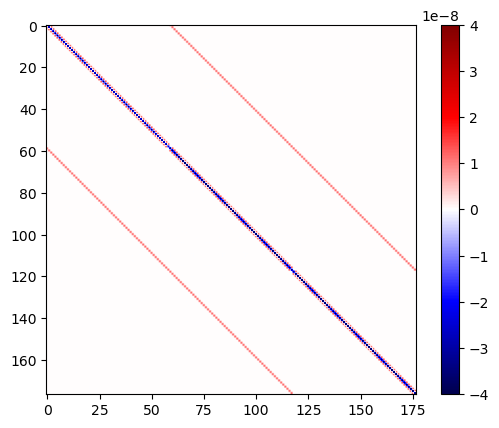

In [26]:
plt.imshow(A[0:3*m,0:3*m].todense(),cmap = 'seismic')
plt.colorbar()
plt.clim([-4e-8,4e-8])
plt.show()

solve Ax = b

[-189784.44 -189784.45 -189784.45 ... -189786.94 -189786.94 -189786.94]
residual:  3.388344694272789e-08


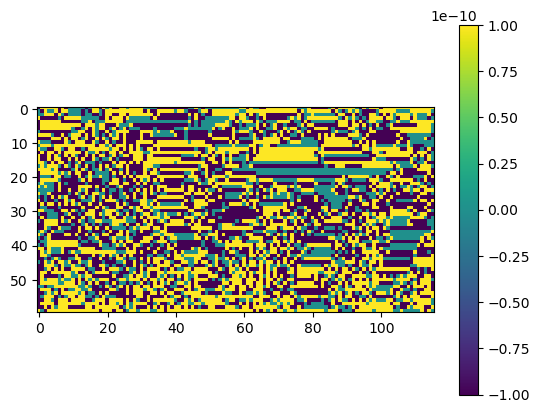

In [105]:
res = []
solver = pyamg.smoothed_aggregation_solver(A)
x1 = solver.solve(b.astype(np.float32), tol=1e-10, residuals=res)
print(x1)
print("residual: ", np.linalg.norm(b-A*x1)) 
b_sol = (A * x1).reshape(n,m) 
plt.imshow(b_sol)
plt.colorbar()
plt.clim([-1e-10, 1e-10])

In [28]:
x2, istop, itn, r1norm = linalg.lsqr(A,b)[:4]

[-7.12010672e-01 -7.09229184e-01 -7.04322750e-01 ... -6.71498526e-03
 -5.55479310e-04  6.03159076e-03]


<Figure size 640x480 with 0 Axes>

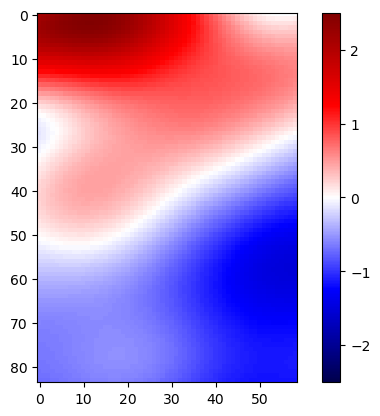

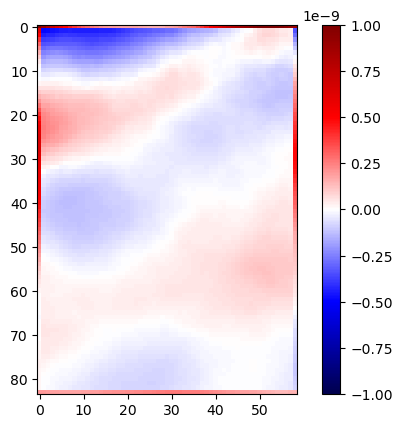

<Figure size 640x480 with 0 Axes>

In [97]:
print(x2)
plt.imshow(np.flip(x2.reshape(n,m),0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.figure()


b_re = (A * x2).reshape(n,m) 
plt.imshow(np.flip(b_re,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-1e-9, 1e-9])
plt.figure()

<Figure size 640x480 with 0 Axes>

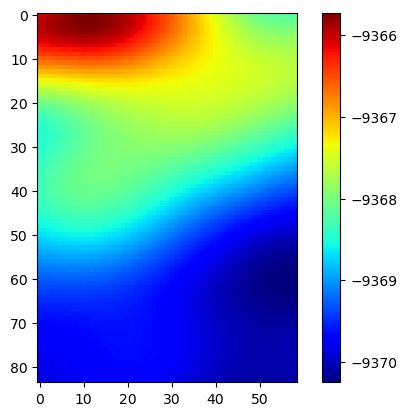

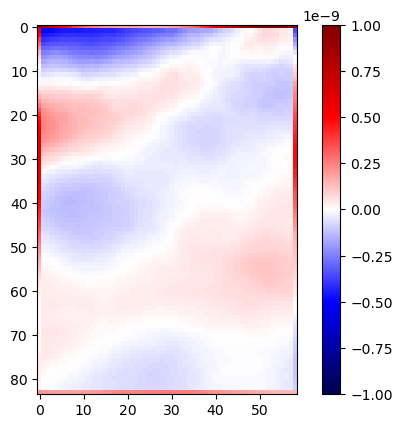

<Figure size 640x480 with 0 Axes>

In [36]:
plt.imshow(np.flip(x.reshape(n,m),0),cmap = 'jet')
plt.colorbar()
# plt.clim([-1e-9, 1e-9])
plt.figure()

b_re = (A * x).reshape(n,m) 
plt.imshow(np.flip(b_re,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-1e-9, 1e-9])
plt.figure()

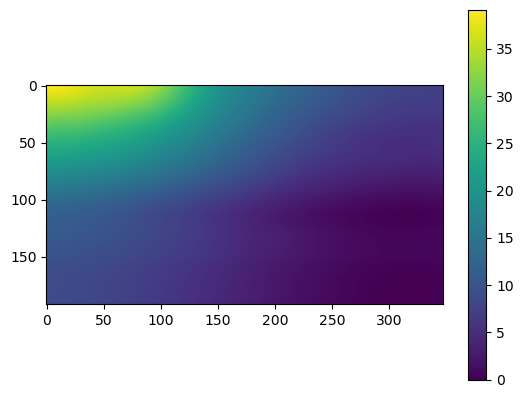

In [205]:
plt.imshow(x.reshape(n,m)-np.min(x))
plt.colorbar()
# plt.clim([0, 20])

## Bernoulli from fluxes

In [70]:

XG_sub = [287, 292]
YG_sub = [28, 35]

delta_index = 21

year = years[0]

for itime in ntimes[0]:    
    # read files
    ds = open_mdsdataset(op.join(ddir,'memb%02d/run%4d/ocn/' % (100,year)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], 
                                 delta_t=2e2, iters=itime,
                                 chunks={'XC':xchunk,'XG':xchunk,'YC':ychunk,'YG':ychunk}
                                ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                      YG=slice(ystart-12**-1,yend+2*12**-1))

    dsb = xr.open_zarr(op.join(savedir,twadir,'run%4d/Dynb/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    dsz = xr.open_zarr(op.join(savedir,twadir,'run%4d/Zetab/%010d/' 
                               % (year,itime))
                      ).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                            YG=slice(ystart-12**-1,yend+2*12**-1)
                           ).reset_coords(drop=True)
    
    delta = .5*(dsz.delta_outer[1:].data 
                + dsz.delta_outer[:-1].data)
    dsz.coords['delta'] = ('delta',delta)

    gridz = Grid(dsz, periodic=['X'], 
                coords={'Z':{'center':'delta','outer':'delta_outer'},
                        'Y':{'center':'YC','left':'YG'},
                        'X':{'center':'XC','left':'XG'}}
           )

    buoyb = -grav * dsz.delta * rho0**-1
   
    sigmab = (dsz.dzetab * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmaxb = (dsz.dzetaxb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    sigmayb = (dsz.dzetayb * -gridz.diff(buoyb,'Z',boundary='extend')**-1)
    
    grid = Grid(ds, periodic=['X'])
    dxC_r = ds.dxC ** -1 
    dyC_r = ds.dyC ** -1
    
    dsJ = xr.open_zarr(op.join(savedir,twadir,'run%4d/mean_PV_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Ju = dsJ.Ju.isel(delta_outer = delta_index)
    Jv = dsJ.Jv.isel(delta_outer = delta_index)
   
    dsF = xr.open_zarr(op.join(savedir,twadir,'run%4d/Eddy_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Fu = dsF.Fu.isel(delta_outer = delta_index)
    Fv = dsF.Fv.isel(delta_outer = delta_index)
    
    dsG = xr.open_zarr(op.join(savedir,twadir,'run%4d/Diabatic_flux/%010d/' 
                               % (year,itime))
                      ).reset_coords(drop=True).sel(YC=slice(ystart-12**-1,yend+2*12**-1),
                                  YG=slice(ystart-12**-1,yend+2*12**-1)
                                                   ).chunk({'YC':ychunk,'XC':xchunk})
    Gu = dsG.Gu.isel(delta_outer = delta_index)
    Gv = dsG.Gv.isel(delta_outer = delta_index)
    
   
    if itime == ntimes[0,0]:
        # thickness-weighted flux
        JJu = Ju * sigmaxb.isel(delta_outer = delta_index)
        JJv = Jv * sigmayb.isel(delta_outer = delta_index)
        
        FFu = Fu * sigmaxb.isel(delta_outer = delta_index)
        FFv = Fv * sigmayb.isel(delta_outer = delta_index)
        
        GGu = Gu * sigmaxb.isel(delta_outer = delta_index)
        GGv = Gv * sigmayb.isel(delta_outer = delta_index)
        
    else:
        JJu = xr.concat([JJu, Ju * sigmaxb.isel(delta_outer = delta_index)], 'itime')
        JJv = xr.concat([JJv, Jv * sigmayb.isel(delta_outer = delta_index)], 'itime')
        
        FFu = xr.concat([FFu, Fu * sigmaxb.isel(delta_outer = delta_index)], 'itime')
        FFv = xr.concat([FFv, Fv * sigmayb.isel(delta_outer = delta_index)], 'itime')
        
        GGu = xr.concat([GGu, Gu * sigmaxb.isel(delta_outer = delta_index)], 'itime')
        GGv = xr.concat([GGv, Gv * sigmayb.isel(delta_outer = delta_index)], 'itime')

    ds.close()

<Figure size 640x480 with 0 Axes>

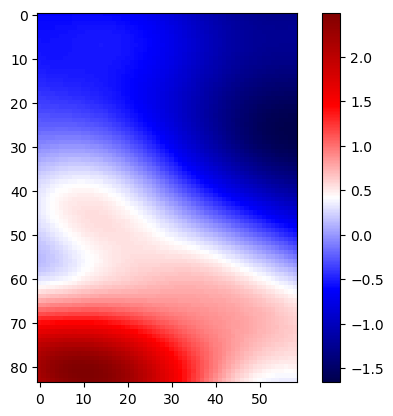

<Figure size 640x480 with 0 Axes>

In [87]:
# time-mean PV flux        
JJu_mean = JJu.mean('itime')
JJv_mean = JJv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g_w = - grid.interp(JJv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g_e = grid.interp(JJv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g_n = - grid.interp(JJu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)
g_s = grid.interp(JJu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)

# RHS f = nabla2B = (dxJv - dyJu)
f = ((grid.diff(JJv_mean * ds.dyC, 'X') 
     - grid.diff(JJu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = mask.XG, 
    YG = mask.YG)

solJ, istopJ, itnJ, r1normJ = bernoulli(f, g_w, g_e, g_n, g_s, hx2, hy2)



# time-mean eddy flux        
FFu_mean = FFu.mean('itime')
FFv_mean = FFv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g2_w = - grid.interp(FFv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g2_e = grid.interp(FFv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g2_n = - grid.interp(FFu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)
g2_s = grid.interp(FFu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)

# RHS f = nabla2B = (dxJv - dyJu)
f2 = ((grid.diff(FFv_mean * ds.dyC, 'X') 
     - grid.diff(FFu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = mask.XG, 
    YG = mask.YG)

solF, istopF, itnF, r1normF = bernoulli(f2, g2_w, g2_e, g2_n, g2_s, hx2, hy2)



# time-mean eddy flux        
GGu_mean = GGu.mean('itime')
GGv_mean = GGv.mean('itime')

# boundary conditions g * n = nablaB * n = (Jv, -Ju) *n 
g3_w = - grid.interp(GGv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g3_e = grid.interp(GGv_mean, 'X').sel(
    XG = mask.XG, 
    YG = mask.YG)
g3_n = - grid.interp(GGu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)
g3_s = grid.interp(GGu_mean, 'Y').sel(
    XG = mask.XG, 
    YG = mask.YG)

# RHS f = nabla2B = (dxJv - dyJu)
f3 = ((grid.diff(GGv_mean * ds.dyC, 'X') 
     - grid.diff(GGu_mean * ds.dxC, 'Y')
    ) * ds.rAz ** -1).sel(
    XG = mask.XG, 
    YG = mask.YG)


solG, istopG, itnG, r1normG = bernoulli(f3, g3_w, g3_e, g3_n, g3_s, hx2, hy2)


<Figure size 640x480 with 0 Axes>

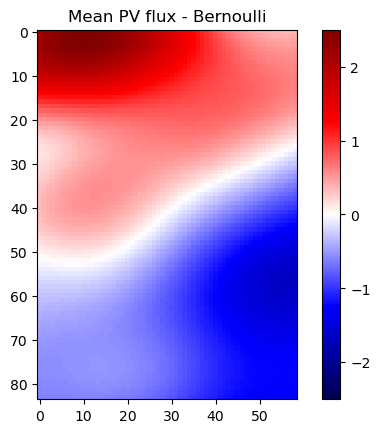

<Figure size 640x480 with 0 Axes>

In [91]:
plt.imshow(np.flip(solJ,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.title('Mean PV flux - Bernoulli')
plt.figure()

<Figure size 640x480 with 0 Axes>

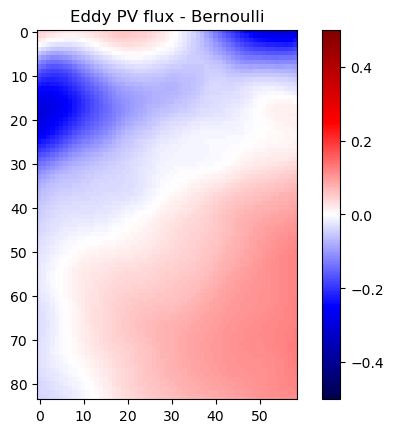

<Figure size 640x480 with 0 Axes>

In [93]:

plt.imshow(np.flip(solF,0),cmap = 'seismic')
plt.colorbar()
plt.title('Eddy PV flux - Bernoulli')
plt.clim([-.5, .5])
plt.figure()

<Figure size 640x480 with 0 Axes>

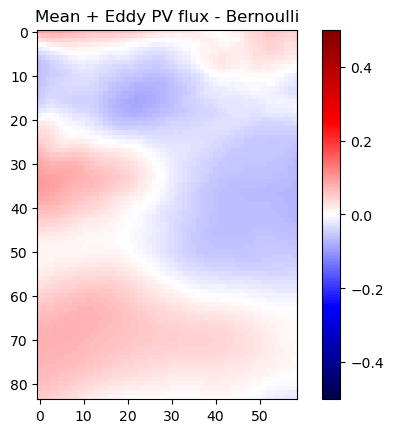

<Figure size 640x480 with 0 Axes>

In [99]:

plt.imshow(np.flip(solJ+solF-x2.reshape(n,m),0),cmap = 'seismic')
plt.colorbar()
plt.title('Mean + Eddy PV flux - Bernoulli')
plt.clim([-.5, .5])
plt.figure()

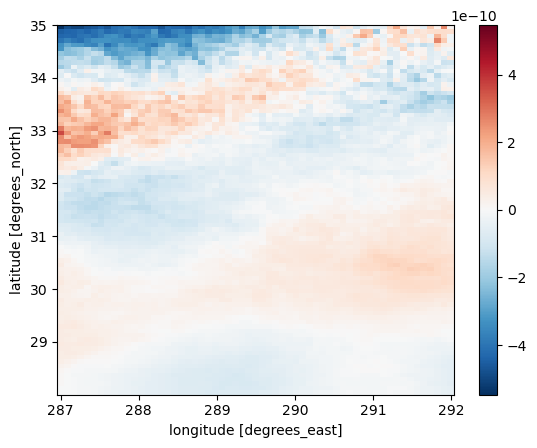

In [84]:
(f+f2).plot()

<Figure size 640x480 with 0 Axes>

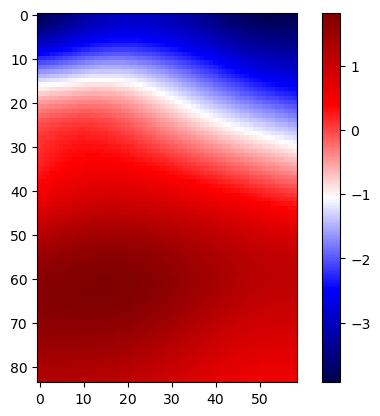

<Figure size 640x480 with 0 Axes>

[-0.12055958 -0.11869515 -0.11598912 ... -0.64459398 -0.64138772
 -0.63677011]


<Figure size 640x480 with 0 Axes>

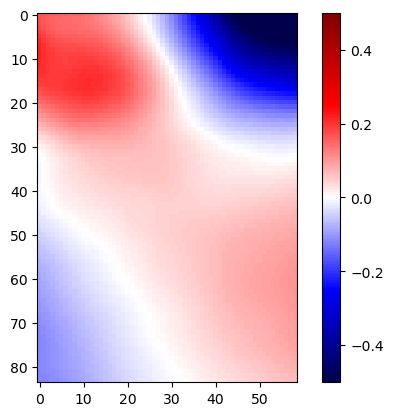

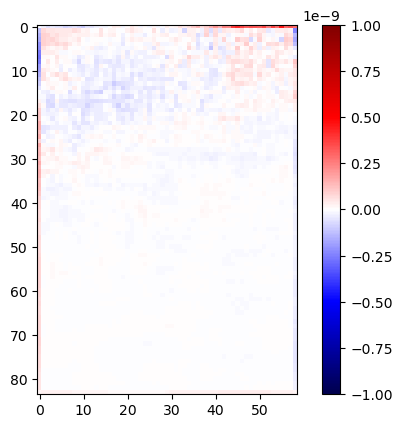

<Figure size 640x480 with 0 Axes>

In [79]:
print(sol2)
plt.imshow(np.flip(sol2.reshape(n,m),0),cmap = 'seismic')
plt.colorbar()
plt.clim([-.5, .5])
plt.figure()


b_re = (A * sol2).reshape(n,m) 
plt.imshow(np.flip(b_re,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-1e-9, 1e-9])
plt.figure()

In [71]:
print(['residual: ', r1norm])

['residual: ', 1.4066549528051513e-09]


[ 1.37127861  1.36967401  1.3669189  ... -3.27222835 -3.2648612
 -3.258202  ]


<Figure size 640x480 with 0 Axes>

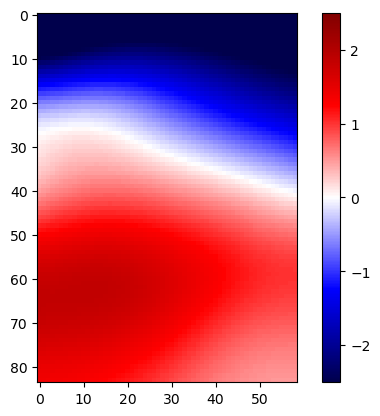

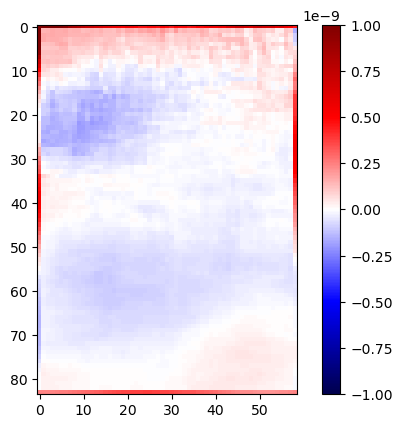

<Figure size 640x480 with 0 Axes>

In [68]:
print(sol)
plt.imshow(np.flip(sol.reshape(n,m),0),cmap = 'seismic')
plt.colorbar()
plt.clim([-2.5, 2.5])
plt.figure()


b_re = (A * sol).reshape(n,m) 
plt.imshow(np.flip(b_re,0),cmap = 'seismic')
plt.colorbar()
plt.clim([-1e-9, 1e-9])
plt.figure()

## accuracy

In [43]:
ds

<xarray.Dataset>
Dimensions:  (time: 1, XC: 1000, YC: 783, XG: 1000, YG: 783, Z: 46, Zp1: 47,
              Zu: 46, Zl: 46)
Coordinates: (12/33)
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) timedelta64[ns] 3645 days
  * XC       (XC) >f4 262.0 262.1 262.2 262.3 262.3 ... 347.7 347.8 347.9 348.0
  * YC       (YC) >f4 -15.08 -15.0 -14.92 -14.83 ... 49.83 49.92 50.0 50.08
  * XG       (XG) >f4 262.0 262.0 262.1 262.2 262.3 ... 347.7 347.8 347.8 347.9
  * YG       (YG) >f4 -15.04 -14.96 -14.87 -14.79 ... 49.88 49.96 50.04 50.13
    ...       ...
    maskW    (Z, YC, XG) bool dask.array<chunksize=(46, 392, 250), meta=np.ndarray>
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 391, 250), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(392, 250), meta=np.ndarray>
    rhoRef   (Z) >f4 dask.array<chunksize=(46,), meta=np.ndarray>
    maskInW  (YC, XG) bool dask.array<chunksize=(392, 250), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(391, 250), meta=np.ndarray>
Data variables:
    THETA    (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    SALT     (time, Z, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    UVEL     (time, Z, YC, XG) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
    VVEL     (time, Z, YG, XC) >f4 dask.array<chunksize=(1, 46, 391, 250), meta=np.ndarray>
    WVEL     (time, Zl, YC, XC) >f4 dask.array<chunksize=(1, 46, 392, 250), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [1]:
sigmab

NameError: name 'sigmab' is not defined